In [1]:
import PIL
from keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import os
from tensorflow.keras import callbacks
import pandas as pd
from efficientnet.keras import EfficientNetB5 as Net
from efficientnet.keras import center_crop_and_resize, preprocess_input
from tensorflow.keras.models import load_model
import tensorflow.keras as keras
from keras import models
from tensorflow.keras.models import Model, model_from_json
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import EfficientNetB5

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
#################### 🌷 Library preparation 🌷 ####################

## Webpage libraries
from flask import Flask, request, render_template, send_from_directory
import requests

## Other libraries
import os
from PIL import Image
from io import BytesIO
import cv2
import json
import uuid
from pathlib import Path
from datetime import date

from tensorflow.keras.preprocessing import image as TFimage
import tensorflow as tf
from tensorflow.keras.preprocessing import image as KImage
from tensorflow.keras.models import load_model
from efficientnet.tfkeras import preprocess_input
import numpy as np
import cv2

## Token 
import pytz
from dateutil import parser

#################### 🌷 Models loading 🌷 ####################

# 📟 EffNet-B5 model for 15AB classify 
model = load_model('/media/tohn/HDD2/Model_unlearn/Models_USAI/ML-unlearn/R2/unfreezeB4-B7/models/modelEffNetB5_ML-unlearn_unfreezeB4-B7-R2.h5')
height = width = model.input_shape[1]

In [3]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
new_input (InputLayer)       [(None, 456, 456, 3)]     0         
_________________________________________________________________
efficientnet-b5 (Functional) (None, None, None, 2048)  28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
prediction_layer (Dense)     (None, 15)                30735     
Total params: 28,544,255
Trainable params: 26,859,743
Non-trainable params: 1,684,512
_________________________________________________________________


In [4]:
dataframe = pd.read_csv('/media/tohn/HDD/VISION_dataset/Testdf_fold1_2_v1.csv')
print(dataframe.shape)
dataframe.head()

(1312, 27)


,Unnamed: 0,Case,Abs Position,Sub Position,Class,Path Full,Path Crop,Views,fold,15AB,...,Rwidth,Rheight,Sub_class_New,tag_AjNit,tag_AjWan,Test150,Spilt,Sub_Position_New,filename,Sub_Position_Label
0,111,40,P1,P1,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,2,MildFattyLiver,...,0.513514,0.346614,AB01,NaN,NaN,False,Test,P1,AB01 P1 C040.JPG,P1
1,112,40,P2,P2,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,2,MildFattyLiver,...,0.560377,0.428287,AB01,NaN,NaN,False,Test,P2,AB01 P2 C040.JPG,P2
2,113,40,P4,P41,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-B,2,MildFattyLiver,...,0.667984,0.711155,AB01,NaN,NaN,False,Test,P4,AB01 P4-1 C040.JPG,P4
3,114,40,P5,P51,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-C,2,MildFattyLiver,...,0.690385,0.653386,AB01,NaN,NaN,False,Test,P6,AB01 P5-1 C040.JPG,P6
4,115,40,P3,P31,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-B,2,MildFattyLiver,...,0.672515,0.625498,AB01,NaN,NaN,False,Test,P3,AB01 P3-1 C040.JPG,P3


In [5]:
labels =  {0: 'AB01', 1: 'AB02', 2: 'AB03', 3: 'AB04', 4: 'AB05', 5: 'AB06', 6: 'AB07', 
           7: 'AB081', 8: 'AB082', 9: 'AB083', 10: 'AB09', 11: 'AB10', 12: 'AB11', 13: 'AB12', 14: 'Normal'}


ABnormalities = {'AB01': 'Mild Fatty Liver', 'AB02': 'Moderate Fatty Liver', 'AB03': 'Severe Fatty Liver', 
                 'AB04': 'Cirrhosis', 'AB05': 'PDF level 1', 'AB06': 'PDF level 2', 'AB07': 'PDF level 3', 'AB081': 'Liver Mass',
                 'AB082': 'Bile Duct Dilatation - IHD stone', 'AB083': 'Liver Mass and Bile Duct Dilatation', 
                 'AB09': 'Gallbladder Stone','AB10': 'Gallbladder-Mass,Polyp,Sludg', 'AB11': 'Renal Abnormalities - Hydronephrosis',
                 'AB12': 'Splenomegaly - Spleen Abnormalities','Normal': 'Normal'}

In [6]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    result1 = result[0]


    return result1 

In [7]:
dataframe = dataframe
dataframe

,Unnamed: 0,Case,Abs Position,Sub Position,Class,Path Full,Path Crop,Views,fold,15AB,...,Rwidth,Rheight,Sub_class_New,tag_AjNit,tag_AjWan,Test150,Spilt,Sub_Position_New,filename,Sub_Position_Label
0,111,40,P1,P1,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,2,MildFattyLiver,...,0.513514,0.346614,AB01,NaN,NaN,False,Test,P1,AB01 P1 C040.JPG,P1
1,112,40,P2,P2,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,2,MildFattyLiver,...,0.560377,0.428287,AB01,NaN,NaN,False,Test,P2,AB01 P2 C040.JPG,P2
2,113,40,P4,P41,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-B,2,MildFattyLiver,...,0.667984,0.711155,AB01,NaN,NaN,False,Test,P4,AB01 P4-1 C040.JPG,P4
3,114,40,P5,P51,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-C,2,MildFattyLiver,...,0.690385,0.653386,AB01,NaN,NaN,False,Test,P6,AB01 P5-1 C040.JPG,P6
4,115,40,P3,P31,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-B,2,MildFattyLiver,...,0.672515,0.625498,AB01,NaN,NaN,False,Test,P3,AB01 P3-1 C040.JPG,P3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,6550,350,P3,P32,Normal,/media/tohn/HDD/VISION_dataset/USAI/US images ...,/media/tohn/HDD/VISION_dataset/USAI/US images ...,FP-B,2,Normal,...,NaN,NaN,Normal,NaN,NaN,False,Test,P9,P3-2.Case 350.JPG,P9
1308,6551,350,P4,P42,Normal,/media/tohn/HDD/VISION_dataset/USAI/US images ...,/media/tohn/HDD/VISION_dataset/USAI/US images ...,FP-B,2,Normal,...,NaN,NaN,Normal,Easy,Easy,False,Test,P5,P4-2.Case 350.JPG,P5
1309,6552,350,P5,P52,Normal,/media/tohn/HDD/VISION_dataset/USAI/US images ...,/media/tohn/HDD/VISION_dataset/USAI/US images ...,FP-C,2,Normal,...,NaN,NaN,Normal,Easy,Easy,True,Test,None,P5-2.Case 350.JPG,P7
1310,6553,350,P6,P61,Normal,/media/tohn/HDD/VISION_dataset/USAI/US images ...,/media/tohn/HDD/VISION_dataset/USAI/US images ...,FP-C,2,Normal,...,NaN,NaN,Normal,Hard,Easy,True,Test,P14,P6.Case 350.JPG,P14


In [8]:
top1_list, top2_list, top3_list = [], [], []
correct_top1, correct_top2, correct_top3 = [], [], []
pred_list,  prob_list= [], []


for img in range(len(dataframe)):
    print(f'on process----{1+img}/{len(dataframe)}')
    result1 = predict_image(dataframe['Path Crop'][img], model)
    
    # === เก็บ top 1 ไปวัดประสิทธิภาพของ AI model ===
    result0 = np.argmax(result1)
    pred_list.append(labels[result0])
    prob_list.append(result1[result0])
    
    
    top3_idx  = result1.argsort()[::-1][:3]  # index top-3
    top3_lab  = [labels[i] for i in top3_idx]
    top3_prob = [float(result1[i]) for i in top3_idx]


    # === Label จริง + Mapping ชื่อโรค ===
    true_lab = dataframe.loc[img, 'Sub_class_New']
    true_lab_with_name = f"{true_lab}: {ABnormalities[true_lab]}"
    dataframe.loc[img, 'Actual class'] = true_lab_with_name


#     # ฟิลเตอร์: แสดงเฉพาะ prob >= 0.01%
    filtered = [
        (lab, prob) for lab, prob in zip(top3_lab, top3_prob) if prob*100 >= 0.00001
    ]

    # === กำหนด threshold สำหรับสลับเป็น scientific notation (หน่วย %)
    SCIENCE_THRESHOLD_PCT = 0.0001  # 0.0001%  ==  1e-6 ในหน่วยความน่าจะเป็น

    # helper: แปลง prob (0..1) -> string ตามกติกา
    def fmt_prob(p):
        pct = p * 100.0
        # ถ้า ≤ 0.0001% ให้แสดงแบบวิทยาศาสตร์
        return f"{pct:.2e}%" if pct <= SCIENCE_THRESHOLD_PCT else f"{pct:.2f}%"

    # ---------------------------------------
    topk = list(zip(top3_lab, top3_prob))  # [(label, prob0..1), ...]

    # === Top1 ===
    top1 = f"{topk[0][0]}: {ABnormalities[topk[0][0]]} {fmt_prob(topk[0][1])}"
    top1_list.append(top1)

    # === Top2 ===
    top2 = [
        f"{topk[0][0]}: {ABnormalities[topk[0][0]]} {fmt_prob(topk[0][1])}",
        f"{topk[1][0]}: {ABnormalities[topk[1][0]]} {fmt_prob(topk[1][1])}",
    ]
    top2_list.append(top2)

    # === Top3 ===
    top3 = [
        f"{topk[0][0]}: {ABnormalities[topk[0][0]]} {fmt_prob(topk[0][1])}",
        f"{topk[1][0]}: {ABnormalities[topk[1][0]]} {fmt_prob(topk[1][1])}",
        f"{topk[2][0]}: {ABnormalities[topk[2][0]]} {fmt_prob(topk[2][1])}",
    ]
    top3_list.append(top3)


    # === Correct/False (cascade ตามเงื่อนไขที่กำหนด) ===
    pred_labels = [lab for lab, _ in topk]  # เอาเฉพาะ label ของ top-k ที่ผ่าน filter

    if len(pred_labels) >= 1 and true_lab == pred_labels[0]:
        # Top1 ถูก
        correct_top1.append(1); correct_top2.append(1); correct_top3.append(1)
    elif len(pred_labels) >= 2 and true_lab in pred_labels[:2]:
        # Top1 ไม่ถูก แต่ Top2 ถูก
        correct_top1.append(0); correct_top2.append(1); correct_top3.append(1)
    elif len(pred_labels) >= 3 and true_lab in pred_labels[:3]:
        # Top1, Top2 ไม่ถูก แต่ Top3 ถูก
        correct_top1.append(0); correct_top2.append(0); correct_top3.append(1)
    else:
        # ไม่มีถูกเลย
        correct_top1.append(0); correct_top2.append(0); correct_top3.append(0)

    
# เพิ่มคอลัมน์ใน DataFrame
dataframe['Top1'] = top1_list
dataframe['Top2'] = top2_list
dataframe['Top3'] = top3_list
dataframe['Correct_Top1'] = correct_top1
dataframe['Correct_Top2'] = correct_top2
dataframe['Correct_Top3'] = correct_top3
dataframe['Effnet_Predict'] = pred_list
dataframe['Effnet_Prob'] = prob_list


on process----1/1312
on process----2/1312
on process----3/1312
on process----4/1312
on process----5/1312
on process----6/1312
on process----7/1312
on process----8/1312
on process----9/1312
on process----10/1312
on process----11/1312
on process----12/1312
on process----13/1312
on process----14/1312
on process----15/1312
on process----16/1312
on process----17/1312
on process----18/1312
on process----19/1312
on process----20/1312
on process----21/1312
on process----22/1312
on process----23/1312
on process----24/1312
on process----25/1312
on process----26/1312
on process----27/1312
on process----28/1312
on process----29/1312
on process----30/1312
on process----31/1312
on process----32/1312
on process----33/1312
on process----34/1312
on process----35/1312
on process----36/1312
on process----37/1312
on process----38/1312
on process----39/1312
on process----40/1312
on process----41/1312
on process----42/1312
on process----43/1312
on process----44/1312
on process----45/1312
on process----46/13

on process----362/1312
on process----363/1312
on process----364/1312
on process----365/1312
on process----366/1312
on process----367/1312
on process----368/1312
on process----369/1312
on process----370/1312
on process----371/1312
on process----372/1312
on process----373/1312
on process----374/1312
on process----375/1312
on process----376/1312
on process----377/1312
on process----378/1312
on process----379/1312
on process----380/1312
on process----381/1312
on process----382/1312
on process----383/1312
on process----384/1312
on process----385/1312
on process----386/1312
on process----387/1312
on process----388/1312
on process----389/1312
on process----390/1312
on process----391/1312
on process----392/1312
on process----393/1312
on process----394/1312
on process----395/1312
on process----396/1312
on process----397/1312
on process----398/1312
on process----399/1312
on process----400/1312
on process----401/1312
on process----402/1312
on process----403/1312
on process----404/1312
on process-

on process----719/1312
on process----720/1312
on process----721/1312
on process----722/1312
on process----723/1312
on process----724/1312
on process----725/1312
on process----726/1312
on process----727/1312
on process----728/1312
on process----729/1312
on process----730/1312
on process----731/1312
on process----732/1312
on process----733/1312
on process----734/1312
on process----735/1312
on process----736/1312
on process----737/1312
on process----738/1312
on process----739/1312
on process----740/1312
on process----741/1312
on process----742/1312
on process----743/1312
on process----744/1312
on process----745/1312
on process----746/1312
on process----747/1312
on process----748/1312
on process----749/1312
on process----750/1312
on process----751/1312
on process----752/1312
on process----753/1312
on process----754/1312
on process----755/1312
on process----756/1312
on process----757/1312
on process----758/1312
on process----759/1312
on process----760/1312
on process----761/1312
on process-

on process----1073/1312
on process----1074/1312
on process----1075/1312
on process----1076/1312
on process----1077/1312
on process----1078/1312
on process----1079/1312
on process----1080/1312
on process----1081/1312
on process----1082/1312
on process----1083/1312
on process----1084/1312
on process----1085/1312
on process----1086/1312
on process----1087/1312
on process----1088/1312
on process----1089/1312
on process----1090/1312
on process----1091/1312
on process----1092/1312
on process----1093/1312
on process----1094/1312
on process----1095/1312
on process----1096/1312
on process----1097/1312
on process----1098/1312
on process----1099/1312
on process----1100/1312
on process----1101/1312
on process----1102/1312
on process----1103/1312
on process----1104/1312
on process----1105/1312
on process----1106/1312
on process----1107/1312
on process----1108/1312
on process----1109/1312
on process----1110/1312
on process----1111/1312
on process----1112/1312
on process----1113/1312
on process----11

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix
act = dataframe['Sub_class_New'].array
pred = dataframe['Effnet_Predict'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 89.2530487804878%
              precision    recall  f1-score   support

        AB01       0.81      0.68      0.74        74
        AB02       0.67      0.58      0.62        59
        AB03       0.55      0.63      0.59        19
        AB04       0.96      0.58      0.72        38
        AB05       0.88      0.79      0.84        29
        AB06       0.67      0.67      0.67        21
        AB07       0.85      0.52      0.65        21
       AB081       0.88      0.66      0.75        32
       AB082       0.94      0.57      0.71        28
       AB083       0.62      0.73      0.67        11
        AB09       0.96      0.88      0.92        26
        AB10       0.89      0.80      0.84        10
        AB11       0.96      0.93      0.94        55
        AB12       0.88      0.91      0.89        32
      Normal       0.92      0.99      0.96       857

    accuracy                           0.89      1312
   macro avg       0.83      0.73      0

<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

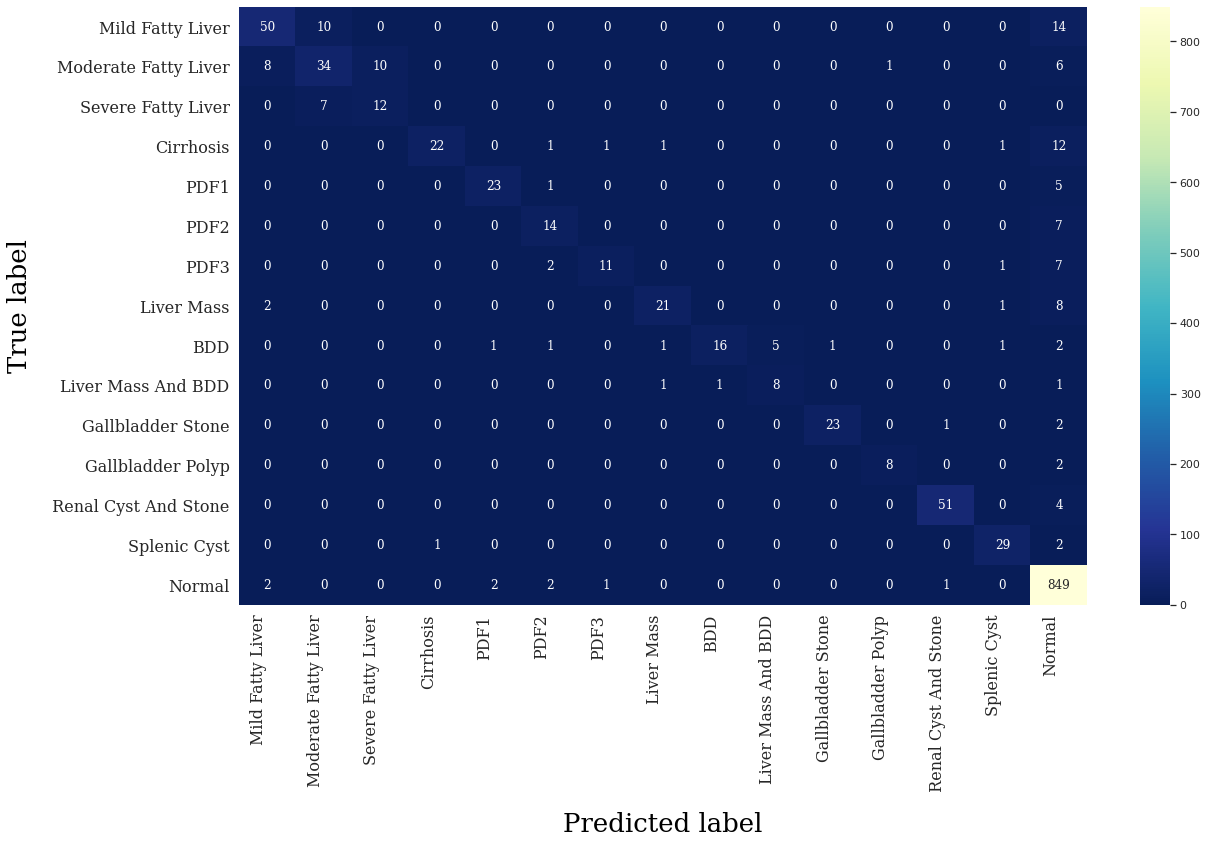

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
classes = np.array(['Mild Fatty Liver','Moderate Fatty Liver','Severe Fatty Liver','Cirrhosis','PDF1',
                    'PDF2','PDF3','Liver Mass','BDD','Liver Mass And BDD','Gallbladder Stone','Gallbladder Polyp',
                    ' Renal Cyst And Stone','Splenic Cyst','Normal'])
def confusion_matrix_normalized(cm,group):
    font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal'}
    cm = cm
    sns.set()
    fig, ax = plt.subplots(figsize=(19, 11))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu_r", annot_kws={'family': 'serif', "size": 12})
    ax.set(xticklabels=classes, yticklabels=classes)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right")
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right")
    ax.set_ylabel('True label',fontsize=26, fontdict=font, labelpad=15)
    ax.set_xlabel('Predicted label',fontsize=26, fontdict=font, labelpad=15)
    hfont = {'fontname':'serif'}
    plt.yticks(fontsize=16, **hfont)
    plt.xticks(fontsize=16, **hfont)

    return ax

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
act = dataframe['Sub_class_New'].array
pred = dataframe['Effnet_Predict'].array
cm = confusion_matrix(act, pred)
cmat = confusion_matrix(act, pred)
acc = (np.trace(cmat))/(np.sum(cmat))
Recall = classification_report(act, pred).split()[-9]
Prec = classification_report(act, pred).split()[-10] 

group = 'with all groups'
confusion_matrix_normalized(cm,group)

<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

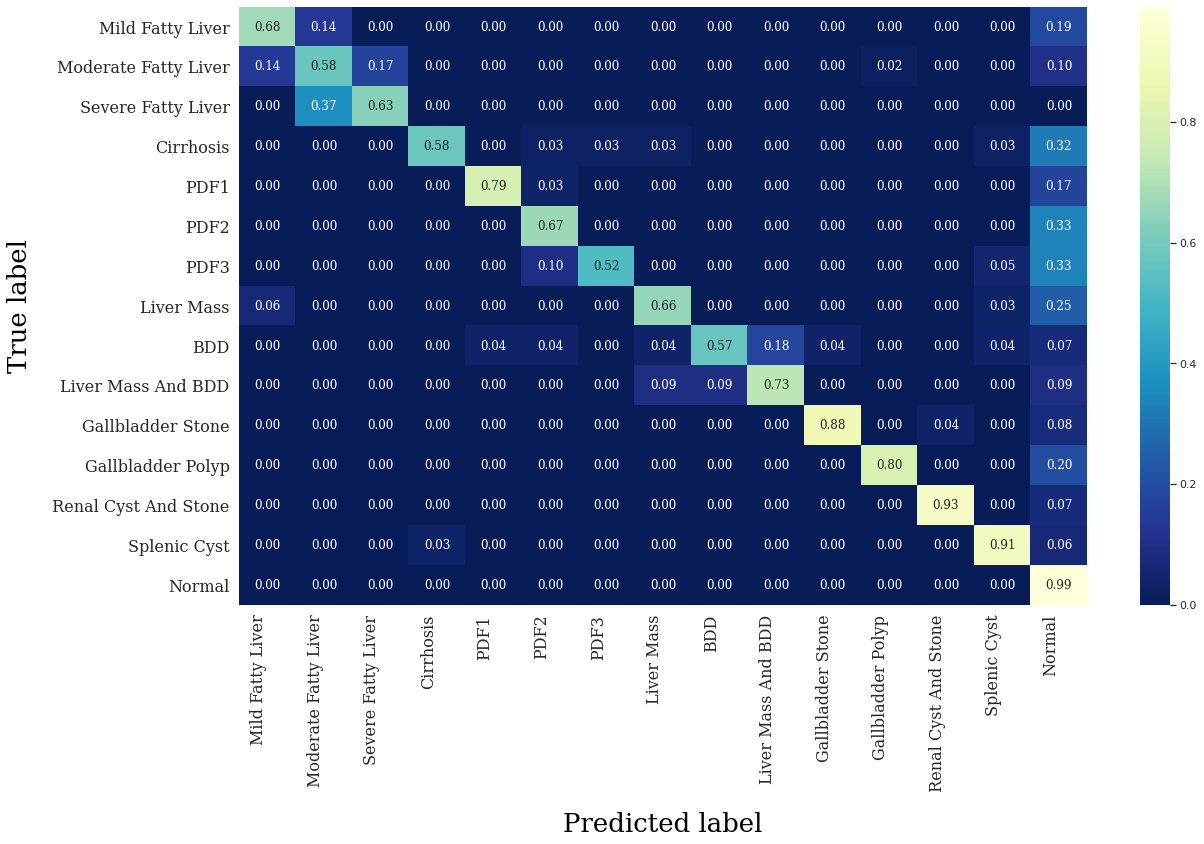

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def confusion_matrix_normalized(cm,group):
    font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal'}
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.set()
    fig, ax = plt.subplots(figsize=(19, 11))
    ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap="YlGnBu_r", annot_kws={'family': 'serif', "size": 12}) #Blues,Oranges,Reds,YlGnBu

    ax.set(xticklabels=classes, yticklabels=classes)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right")
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right")
    ax.set_ylabel('True label',fontsize=26, fontdict=font, labelpad=15)
    ax.set_xlabel('Predicted label',fontsize=26, fontdict=font, labelpad=15)
   
    hfont = {'fontname':'serif'}
    plt.yticks(fontsize=16, **hfont)
    plt.xticks(fontsize=16, **hfont)

    return ax

act = dataframe['Sub_class_New'].array
pred = dataframe['Effnet_Predict'].array
a = confusion_matrix(act, pred)
cmat = confusion_matrix(act, pred)
acc = (np.trace(cmat))/(np.sum(cmat))
Recall = classification_report(act, pred).split()[-9]
Prec = classification_report(act, pred).split()[-10] 

cm = a 
group = 'with all groups'
confusion_matrix_normalized(cm,group)

In [12]:
act= dataframe['Sub_class_New'].map({'AB01':'Abnormal', 'AB02':'Abnormal', 'AB03':'Abnormal', 'AB04':'Abnormal',
 'AB05':'Abnormal','AB06':'Abnormal', 'AB07':'Abnormal', 'AB081':'Abnormal',
 'AB082':'Abnormal', 'AB083':'Abnormal', 'AB09':'Abnormal', 'AB10':'Abnormal',
 'AB11':'Abnormal', 'AB12':'Abnormal', 'Normal':'Normal'}).values
pred = dataframe['Effnet_Predict'].map({'AB01':'Abnormal', 'AB02':'Abnormal', 'AB03':'Abnormal', 'AB04':'Abnormal',
 'AB05':'Abnormal','AB06':'Abnormal', 'AB07':'Abnormal', 'AB081':'Abnormal',
 'AB082':'Abnormal', 'AB083':'Abnormal', 'AB09':'Abnormal', 'AB10':'Abnormal',
 'AB11':'Abnormal', 'AB12':'Abnormal', 'Normal':'Normal'}).values
cmat = confusion_matrix(act, pred)
print('\n    classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print('\n', classification_report(act, pred))#performance


    classifier accuracy = 93.90243902439025%

               precision    recall  f1-score   support

    Abnormal       0.98      0.84      0.91       455
      Normal       0.92      0.99      0.96       857

    accuracy                           0.94      1312
   macro avg       0.95      0.92      0.93      1312
weighted avg       0.94      0.94      0.94      1312



Text(0.5, 28.75, 'Predicted label')

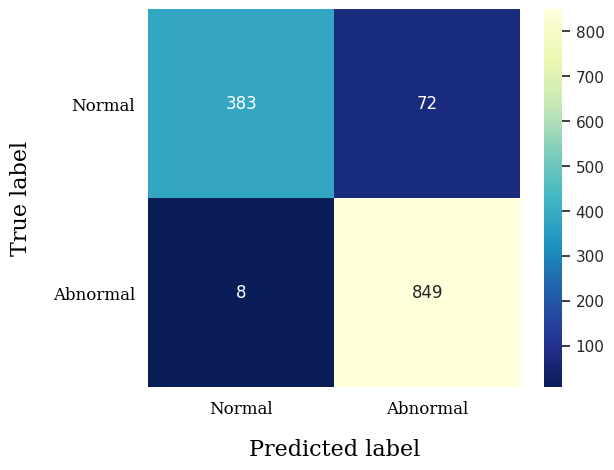

In [13]:
cm = cmat

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal'}
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set()
classes = np.array(['Normal','Abnormal'])
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu_r") #Blues,Oranges,Reds,YlGnBu
ax.set(xticklabels=classes, yticklabels=classes)
ax.set_xticklabels(classes,fontsize=12, fontdict=font)
ax.set_yticklabels(classes,fontsize=12, fontdict=font)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right")
# ax.set_title(f'Confusion matrix (Normal/Abnormal class) \n of  threshold = 0.5 by EfficientNet model  ',fontsize=18, fontdict=font, pad=30)
ax.set_ylabel('True label',fontsize=16, fontdict=font, labelpad=15)
ax.set_xlabel('Predicted label',fontsize=16, fontdict=font, labelpad=15)

In [14]:
dataframe['Test Case'] = dataframe['Actual class']
dataframe['Test Data'] = dataframe['filename']
dataframe['Expected Results (Top3)'] = dataframe['Top3']

dataframe = dataframe[['Test Case','Test Data','Expected Results (Top3)','Correct_Top1', 'Correct_Top2', 'Correct_Top3']]

# save CSV
dataframe.to_csv("prediction_top123_round1.csv", index=False, encoding="utf-8-sig")
# dataframe.to_csv("prediction_top123_round2.csv", index=False, encoding="utf-8-sig")
# dataframe.to_csv("prediction_top123_round3.csv", index=False, encoding="utf-8-sig")

In [15]:
dataframe

,Test Case,Test Data,Expected Results (Top3),Correct_Top1,Correct_Top2,Correct_Top3
0,AB01: Mild Fatty Liver,AB01 P1 C040.JPG,"[Normal: Normal 84.81%, AB02: Moderate Fatty L...",0,0,1
1,AB01: Mild Fatty Liver,AB01 P2 C040.JPG,"[AB01: Mild Fatty Liver 99.99%, Normal: Normal...",1,1,1
2,AB01: Mild Fatty Liver,AB01 P4-1 C040.JPG,"[AB01: Mild Fatty Liver 99.94%, AB02: Moderate...",1,1,1
3,AB01: Mild Fatty Liver,AB01 P5-1 C040.JPG,"[AB01: Mild Fatty Liver 99.99%, AB02: Moderate...",1,1,1
4,AB01: Mild Fatty Liver,AB01 P3-1 C040.JPG,"[AB02: Moderate Fatty Liver 99.14%, AB01: Mild...",0,1,1
...,...,...,...,...,...,...
1307,Normal: Normal,P3-2.Case 350.JPG,"[Normal: Normal 100.00%, AB01: Mild Fatty Live...",1,1,1
1308,Normal: Normal,P4-2.Case 350.JPG,"[Normal: Normal 99.99%, AB05: PDF level 1 0.01...",1,1,1
1309,Normal: Normal,P5-2.Case 350.JPG,"[Normal: Normal 100.00%, AB01: Mild Fatty Live...",1,1,1
1310,Normal: Normal,P6.Case 350.JPG,"[Normal: Normal 100.00%, AB01: Mild Fatty Live...",1,1,1
